### Encoder and Decoder Neural Network 

In [ ]:
# Encoder with LSTM
encoder_inputs = Input(shape=(None,),name="EncoderInput")
enc_emb =  Embedding(vocab_size_normal_text+1,300, mask_zero = True,name="EncoderEmbeddingLayer",weights=[Encoder_embedding_matrix])(encoder_inputs)
encoder_lstm = LSTM(300,activation='tanh',return_state=True,name="EncoderLSTM")

encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Setting up the decoder

decoder_inputs = Input(shape=(None,),name="DecoderInput")
dec_emb_layer = Embedding(vocab_size_eng+1,300,mask_zero = True,name="DecoderEmbeddingLayer",weights=[Decoder_embedding_matrix])
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(300,activation='tanh',return_sequences=True, return_state=True,name="DecoderLSTM")
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)

decoder_dense = Dense(vocab_size_eng, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderEmbeddingLayer (Embeddin (None, None, 300)    3543900     EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderEmbeddingLayer (Embeddin (None, None, 300)    849000      DecoderInput[0][0]               
____________________________________________________________________________________________

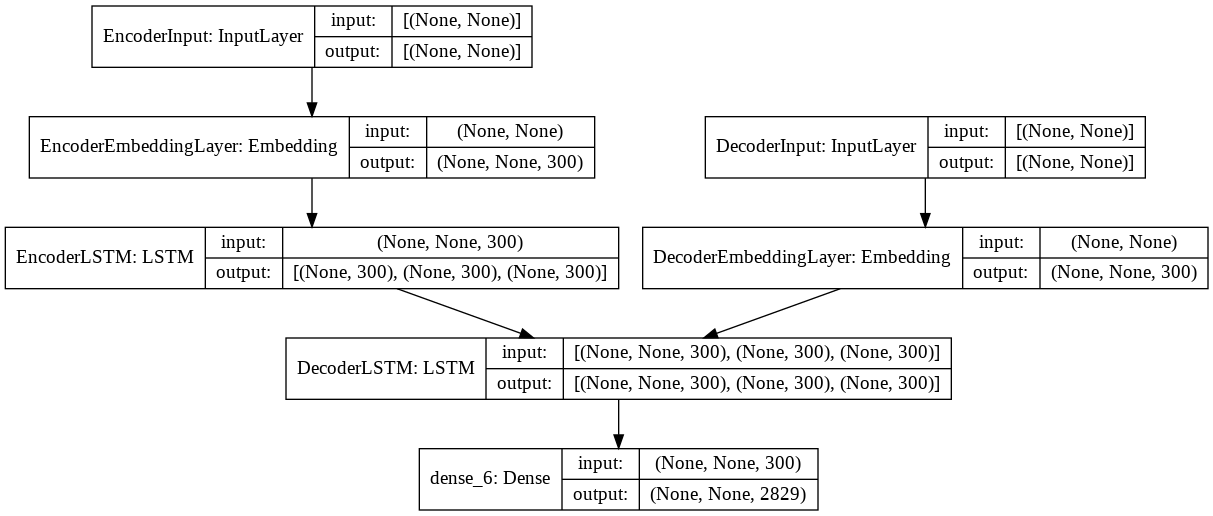

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)

##### Defining the callbacks 

In [ ]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping,TerminateOnNaN,TensorBoard
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
filepath="/content/drive/MyDrive/CaseStudy2/Model-1/weights-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc',  verbose=4, save_best_only=True, mode='auto')
logdir = "/content/drive/MyDrive/CaseStudy2/Model-1/Logs/fit_model2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(logdir)
tensorboard_callback = TensorBoard(log_dir=logdir,histogram_freq=1,profile_batch = 100000000)
callback_list = [checkpoint,tensorboard_callback]

In [ ]:
#Compiling the Model with Adam as optimizer and categorical cross entropy as loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
train_steps=train.shape[0]//100
valid_steps=validation.shape[0]//100

Model_Output=model.fit_generator(train_dataloader,steps_per_epoch=train_steps,epochs=50, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=callback_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
44/44 [==============================] - 13s 137ms/step - loss: 2.1355 - acc: 0.0791 - val_loss: 1.7395 - val_acc: 0.1125

Epoch 00001: val_acc improved from -inf to 0.11248, saving model to /content/drive/MyDrive/CaseStudy2/Model-1/weights-01-0.1125.hdf5
Epoch 2/50
44/44 [==============================] - 4s 86ms/step - loss: 1.7453 - acc: 0.1079 - val_loss: 1.6838 - val_acc: 0.1112

Epoch 00002: val_acc did not improve from 0.11248
Epoch 3/50
44/44 [==============================] - 4s 84ms/step - loss: 1.7068 - acc: 0.1249 - val_loss: 1.6156 - val_acc: 0.1542

Epoch 00003: val_acc improved from 0.11248 to 0.15422, saving model to /content/drive/MyDrive/CaseStudy2/Model-1/weights-03-0.1542.hdf5
Epoch 4/50
44/44 [==============================] - 4s 83ms/step - loss: 1.5513 - acc: 0.1574 - val_loss: 1.5563 - val_acc: 0.1810

Epoch 00004: val_acc improved from 0.15422 to 0.18102, saving model to /content/drive/MyDrive/CaseStudy2/Model-1/weights-04-0.1810.hdf5
Epoch 5/50
44/4

### Inference Setup

In [ ]:
# Encode the input sequence 
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(300,))
decoder_state_input_c = Input(shape=(300,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#dec_emb2= Embedding(vocab_size_eng+1, 50, mask_zero = True,name="DecoderEmbeddingLayer")(decoder_inputs) # Get the embeddings of the decoder sequence
dec_emb2=dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time 

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

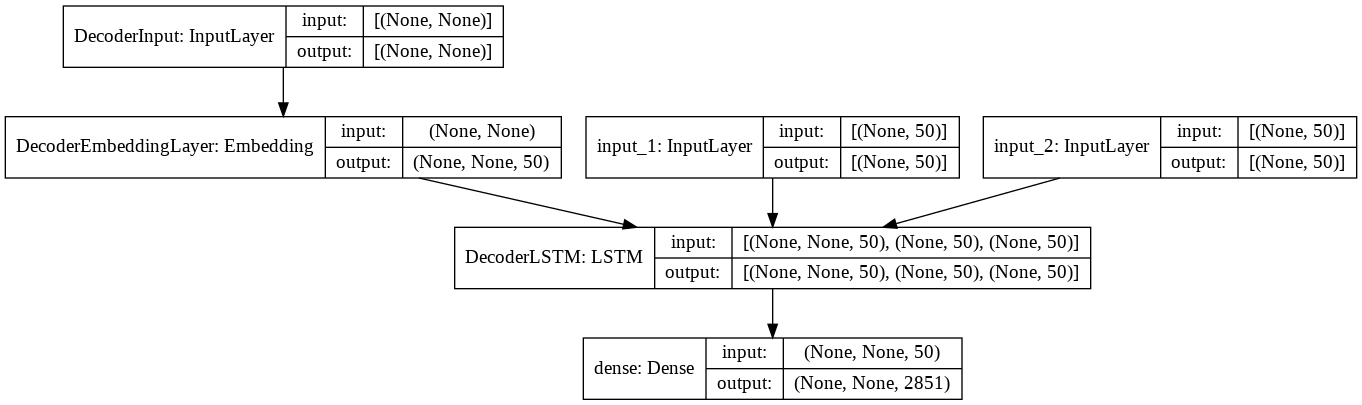

In [ ]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tknizer_english.word_index['start']
    stop_condition = False
    result=''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] +states_value)
        # Sample a token
        predicted_id = np.argmax(output_tokens[0, -1, :])
        result += tknizer_english.index_word[predicted_id] + ' '
        if (tknizer_english.index_word[predicted_id] == 'end' or
           len(result) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = predicted_id

        # Update states
        states_value = [h, c]

    return result

In [ ]:
#This function used to convert the source sentence into respective tensors and getting the decodeed sentence for input sentence
def evaluate(sentence):
  sentence = preprocess(sentence)
  result=''
  predicted_list=[]
  try:
    inputs = [tknizer_normal_text.word_index[i] for i in sentence.split(' ')]
    inputs =  tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=50,padding='post')    
    inputs = tf.convert_to_tensor(inputs)
    result=decode_sequence(inputs)
    predicted_list.append(result)
    print("Source Sentence:-->",sentence)
    print("predicted result:-->",result)
    print("="*50)
    return result,sentence
  except KeyError as e:
    pass      

##### Top 5 predicted Sentences from Validation 

In [ ]:
InputText=list(validation['NormalizedText'].head(5).values)
for input in InputText:
  Predicted_list=evaluate(input)

Source Sentence:--> ohio okey ya sent you a chinese new year poem you too enjoy your chinese novel year
predicted result:--> oh okay ya sent you a new year poem it is good birthday 
Source Sentence:--> buckeye state they were just commenting on its popularity hey your dog looks real cute
predicted result:--> oh they were just commenting on my tests and only in 
Source Sentence:--> wow so other shuhui and ace later on maybe going to take exposure at clementi but not confirmed yet do you want to come
predicted result:--> so so early tomorrow you are going to my house but 
Source Sentence:--> ok haha by the mode you cut short hair is breadth already or not pretty girl haha
predicted result:--> okay then when is the bidding is the bidding is very 
